In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# colab pro 더 빠른 GPU 사용
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 17 05:01:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# colab pro 추가 메모리
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# nltk에서 stopwords 다운로드
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re
import numpy as np
import pandas as pd
import time
#import pyLDAvis
#import pyLDAvis.gensim_models
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from matplotlib import pyplot as plt

import gensim
import string
from gensim import corpora
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import multiprocessing
num_cores = multiprocessing.cpu_count()

# Change this to where your datasets are located:
os.chdir("/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/training_gold_standards") # 현재 디렉토리 설정. 

## 확인 필요. 문제 없으면 지울 수 있음. ##
# Check versions to ensure that there are no compatability issues:
python_version = !python --version
print("Python Version: ", python_version)
print("Current Directory: ", os.getcwd())
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)

Python Version:  ['Python 3.7.12']
Current Directory:  /content/drive/MyDrive/Aiffel_Hackathon/financial_documents/training_gold_standards
Numpy version:  1.19.5
Pandas version:  1.1.5


## Gold Standard Summary
Gold Summary 파일 중에서 text 부분인 "_1" 파일만 csv 파일에 넣어서 리스트를 만들어주고 "_1" 파일을 읽어와서 

In [ ]:
gs_list = os.listdir("/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/training_gold_standards")
len(gs_list)

gs_df = pd.DataFrame(gs_list, columns=['Original_Filename']) 
gs_df['Original_Filename'] = gs_df['Original_Filename'].str.replace('.txt', '') 
gs_df[['Document', 'Middle', 'Section']] = gs_df['Original_Filename'].str.split('_').tolist() 
gs_df.head()

6787

,Original_Filename,Document,Middle,Section
0,19468_698370_8,19468,698370,8
1,19471_701669_8,19471,701669,8
2,19480_703748_8,19480,703748,8
3,19471_701677_1,19471,701677,1
4,19480_703751_1,19480,703751,1


In [ ]:
gs_df = gs_df.loc[gs_df['Section'] == "1"]
print(len(gs_df))
gs_df.head()

3000


,Original_Filename,Document,Middle,Section
3,19471_701677_1,19471,701677,1
4,19480_703751_1,19480,703751,1
7,19483_705473_1,19483,705473,1
9,19484_706125_1,19484,706125,1
11,19485_706628_1,19485,706628,1


In [ ]:
gs_path = []
for path in gs_list:
  if '_1.txt' in path:
    gs_path.append(path)

print(len(gs_path))
gs_path[:5]

3000


['19471_701677_1.txt',
 '19480_703751_1.txt',
 '19483_705473_1.txt',
 '19484_706125_1.txt',
 '19485_706628_1.txt']

In [ ]:
  sample_path = "/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/training_gold_standards/19480_703751_1.txt"
  file = open(sample_path, encoding='utf8')
  text = file.read()
  temp_length = len(text.split()) 
  file.close()

  print(text)

 10 RGI International Limited Annual Report & Accounts 2013
CHAIRMAN’S STATEMENT
With the full support of VEB, the Company has been 
able to push forward with building on the legacy  
of its visionary founder Boris Kuzinez, who created  
a business renowned in Moscow for distinctive, 
aspirational real estate built to a high quality. The  
RGI approach to design and build has been applied 
most recently to its large residential development,  
«V Lesu», in the Moscow Region, where over 30,000 
people will live once the project is completed in 2022. 
Here, a very different kind of neighbourhood is taking 
shape, far removed from most of the mass market 
residential projects that are seen in the suburbs  
of Moscow.
This distinctive look and feel can also be seen at 
Tsvetnoy Central Market, the department store built, 
owned and operated by RGI in the centre of Moscow. 
Both developments have the concept of dynamic 
communities at their heart and it is this key focus, as 
well as design 

In [ ]:
doc_lengths = []
for path in gs_path:
  file = open(path, encoding='utf8')
  text = file.read()
  temp_length = len(text.split()) 
  doc_lengths.append(temp_length)
  file.close()
  
print(len(doc_lengths))

gs_df['Length'] = doc_lengths


3000


In [ ]:
len(gs_df['Length'])

3000

In [ ]:
print(len(gs_df))
gs_df.head()

3000


,Original_Filename,Document,Middle,Section,Length
3,19471_701677_1,19471,701677,1,1714
4,19480_703751_1,19480,703751,1,1031
7,19483_705473_1,19483,705473,1,1015
9,19484_706125_1,19484,706125,1,869
11,19485_706628_1,19485,706628,1,1262


### Training Sections
Analyze the Training Data Sections - similar to above

In [ ]:
train_list = os.listdir("/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/training_sections")
len(train_list)
train_df = pd.DataFrame(train_list, columns=['Original_Filename'])
train_df['Original_Filename'] = train_df['Original_Filename'].str.replace('.txt', '')
train_df[['Document', 'Middle', 'Section']] = train_df['Original_Filename'].str.split('_').tolist()

train_df.head()


3091

,Original_Filename,Document,Middle,Section
0,15786_819157_2,15786,819157,2
1,15783_819108_2,15783,819108,2
2,15782_819091_2,15782,819091,2
3,15787_819176_2,15787,819176,2
4,15816_820156_2,15816,820156,2


In [ ]:
train_df = train_df.loc[train_df['Section'] == "2"]
print(len(train_df))
train_df.head()

3091


,Original_Filename,Document,Middle,Section
0,15786_819157_2,15786,819157,2
1,15783_819108_2,15783,819108,2
2,15782_819091_2,15782,819091,2
3,15787_819176_2,15787,819176,2
4,15816_820156_2,15816,820156,2


In [ ]:
os.chdir("/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/training_sections")

In [ ]:
train_doc_lengths = []
for path in train_list:
  file = open(path, encoding='utf8')
  text = file.read()
  temp_length = len(text.split())
  train_doc_lengths.append(temp_length)
  file.close()

train_df['Length'] = train_doc_lengths


In [ ]:
print(len(train_df))
train_df.head()

3091


,Original_Filename,Document,Middle,Section,Length
0,15786_819157_2,15786,819157,2,2181
1,15783_819108_2,15783,819108,2,1147
2,15782_819091_2,15782,819091,2,882
3,15787_819176_2,15787,819176,2,2203
4,15816_820156_2,15816,820156,2,2032


In [ ]:
train_df = train_df.drop_duplicates(subset=['Document', 'Section'], keep='first')
print(len(train_df))

3005


## Text Length Comparisons
Analyze the Text by word count to get some statistics.

count     3005.000000
mean      2039.665557
std       1478.060387
min          0.000000
25%       1142.000000
50%       1715.000000
75%       2542.000000
max      21742.000000
Name: Length, dtype: float64

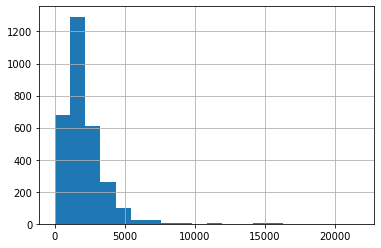

In [ ]:
train_df['Length'].describe()
train_df['Length'].hist(bins=20)

In [ ]:
over4000 = train_df[train_df['Length'] > 4000]
print(len(over4000))
print("ratio: ", len(over4000)/len(train_df['Length'])*100)

216
ratio:  7.18801996672213


In [ ]:
over500 = 500 < train_df['Length']
less4000 = 4000 > train_df['Length']
new_train_df = train_df[over500 & less4000]
len(new_train_df)

2671

In [ ]:
train_data = new_train_df.merge(gs_df, how='left', on=['Document'])
print(len(train_data))
train_data.head()

2671


,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Original_Filename_y,Middle_y,Section_y,Length_y
0,15786_819157_2,15786,819157,2,2181,15786_819156_1,819156,1,1387.0
1,15783_819108_2,15783,819108,2,1147,15783_819107_1,819107,1,950.0
2,15782_819091_2,15782,819091,2,882,15782_819090_1,819090,1,725.0
3,15787_819176_2,15787,819176,2,2203,15787_819175_1,819175,1,642.0
4,15816_820156_2,15816,820156,2,2032,15816_820155_1,820155,1,795.0


count    2666.000000
mean      931.393098
std       540.033564
min         3.000000
25%       623.250000
50%       838.500000
75%      1117.000000
max      8887.000000
Name: Length_y, dtype: float64

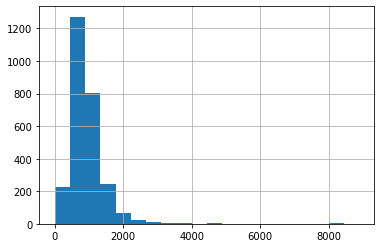

In [ ]:
# gold summary의 길이 확인 
train_data['Length_y'].describe()
train_data['Length_y'].hist(bins=20)

In [ ]:
over200 = train_data['Length_y'] > 200
less1500 = train_data['Length_y'] < 1500
train_data = train_data[over200 & less1500]
len(train_data)
train_data.head()

2408

,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Original_Filename_y,Middle_y,Section_y,Length_y
0,15786_819157_2,15786,819157,2,2181,15786_819156_1,819156,1,1387.0
1,15783_819108_2,15783,819108,2,1147,15783_819107_1,819107,1,950.0
2,15782_819091_2,15782,819091,2,882,15782_819090_1,819090,1,725.0
3,15787_819176_2,15787,819176,2,2203,15787_819175_1,819175,1,642.0
4,15816_820156_2,15816,820156,2,2032,15816_820155_1,820155,1,795.0


### Appending the Data

In [ ]:
os.getcwd()

'/content/drive/My Drive/Aiffel_Hackathon/financial_documents/training_sections'

In [ ]:
train_data.rename(columns={'Original_Filename_y' : 'Gold_Filename',
                            'Section_y' : 'Gold Section',
                            'Length_y' : 'Gold_Summary_Length'}, inplace=True)
train_data.head()

,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Gold_Filename,Middle_y,Gold Section,Gold_Summary_Length
0,15786_819157_2,15786,819157,2,2181,15786_819156_1,819156,1,1387.0
1,15783_819108_2,15783,819108,2,1147,15783_819107_1,819107,1,950.0
2,15782_819091_2,15782,819091,2,882,15782_819090_1,819090,1,725.0
3,15787_819176_2,15787,819176,2,2203,15787_819175_1,819175,1,642.0
4,15816_820156_2,15816,820156,2,2032,15816_820155_1,820155,1,795.0


In [ ]:
train_data.to_csv("/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/Bo_csv_files")

In [ ]:
training_file_list = [x + str(".txt") for x in train_data['Original_Filename_x']]
len(training_file_list)

2408

In [ ]:
# sample로 한개 돌려보기
with open(training_file_list[8], "r", encoding='utf-8') as file:
  temp_str = ''
  for line in file:
    line = line.replace('\n', ' ') 
    temp_str += line 
    
print(temp_str)


 TOPPS TILES PLC Annual Report & Financial Statements 2007 05 CHIEF EXECUTIVE’S STATEMENT WE HAVE AGAIN THIS YEAR  DEMONSTRATED THE STRENGTH OF OUR STRATEGY AND OUR ORGANIC GROWTH. OUR MARKET LEADING POSITION, EXCELLENT CUSTOMER SERVICE AND COMMITTED STAFF HAVE ALL  CONTRIBUTED TO ANOTHER SOLID YEAR DESPITE A TOUGH HOME IMPROVEMENT MARKET. Tile Clearing House (“TCH”) Tile Clearing House, our “cash and carry” offering has had a strong trading period. We have opened a net 9 new TCH outlets and the format continues to prove popular with both trade customers and jobbing builders. We now have a total of 55 stores in the UK. New locations include Dartford, Southend, Plymouth and Lincoln.  Holland Against the backdrop of a stable market, we have seen good growth in sales and profits in our Dutch business. We opened a further five stores taking the total to 20. Our marketing activity has been at a local level to date. However, as we experienced with the UK market, as we begin to reach a size t

In [ ]:
file_path = '/content/drive/My Drive/Aiffel_Hackathon/financial_documents/training_sections/'

sentence_list = [] 
for i in training_file_list: 
  with open(file_path + i, "r", encoding='utf-8') as f: 
    temp_str = '' 
    for line in f: 
      line = line.replace('\n', ' ') 
      temp_str += line 
    sentence_list.append(temp_str)

In [ ]:
len(sentence_list)
sentence_list[10]

2408

" TOPPS TILES PLC  Annual Report and Financial Statements 2005 07 This year, in a turbulent UK trading environment, we have again demonstrated the fundamental strength of our business through the continued delivery of improved profits. Store Development and Expansion                                                                      Our national store opening programme continues apace with a net 24 new stores (20 Topps and 4 Tile Clearing House) opened in this  financial year. We now have a total of 244 trading stores (207 Topps and 37 Tile Clearing House) and are firmly on our way to achieving our stated target of a minimum of 350 UK outlets. We continue to enjoy a good pipeline of suitable sites for occupation or development. In line with our policy of continued store development and  refurbishment, 3 stores were closed or relocated, 15 re-fitted and a net 24 new stores opened in the period. We have a total of 64 stores  offering our tile studio concept of extra choice of up-market

In [ ]:
train_data['Full_Text'] = sentence_list
train_data.head()

,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Gold_Filename,Middle_y,Gold Section,Gold_Summary_Length,Full_Text
0,15786_819157_2,15786,819157,2,2181,15786_819156_1,819156,1,1387.0,6 Chief Executive Officer’s review The ...
1,15783_819108_2,15783,819108,2,1147,15783_819107_1,819107,1,950.0,CHIEF EXECUTIVE OFFICER’S STATEMENT The Bero...
2,15782_819091_2,15782,819091,2,882,15782_819090_1,819090,1,725.0,Chief executive Officer’s statement The Compa...
3,15787_819176_2,15787,819176,2,2203,15787_819175_1,819175,1,642.0,page 6 Toledo Mining Corporation plc Annual R...
4,15816_820156_2,15816,820156,2,2032,15816_820155_1,820155,1,795.0,3 CHIEF EXECUTIVE’S STATEMENT TOMKINS PLC REP...


In [ ]:
summary_file_list = [x + str(".txt") for x in train_data['Gold_Filename']]
print(len(summary_file_list))

2408


In [ ]:
summary_file_path = '/content/drive/My Drive/Aiffel_Hackathon/financial_documents/training_gold_standards/'

summary_list = [] 
for i in summary_file_list: 
  with open(summary_file_path + i, "r", encoding='utf-8') as f: 
    temp_str = '' 
    for line in f: 
      line = line.replace('\n', ' ') 
      temp_str += line 
    summary_list.append(temp_str)

In [ ]:
print(len(summary_list))
summary_list[10]

2408


' TOPPS TILES PLC  Annual Report and Financial Statements 2005 03 I am pleased to report another strong performance by the Group with record profits and increased UK market share.  We have consolidated our position as the leading UK ceramic tile and wood flooring  specialist, backed by what is now a truly national brand. The new Topps Distribution and Marketing Centre is fully integrated with the capacity to support our UK store target of a minimum of 350 stores. The period has seen a particularly weak UK consumer environment, however I am pleased to report the resilience of our business model has enabled us to continue to deliver record results and to outperform the market.   Since flotation in 1997 total shareholder return has grown by over 2,000% and we have consistently been a top performing company in the FTSE Index.  Financial Results Group turnover has increase by 10.0% over the period to £173.3  million, with profit before tax increasing by 16.1% to £39.2 million. Gross margins

In [ ]:
train_data['Summary_Text'] = summary_list

In [ ]:
train_data.set_index(['Original_Filename_x', 'Gold_Filename'], inplace=True)
train_data2 = train_data[['Document', 'Full_Text', 'Summary_Text']]
train_data2.head()

,,Document,Full_Text,Summary_Text
Original_Filename_x,Gold_Filename,,,
15786_819157_2,15786_819156_1,15786,6 Chief Executive Officer’s review The ...,3 Chairman’s statement In the 18 mon...
15783_819108_2,15783_819107_1,15783,CHIEF EXECUTIVE OFFICER’S STATEMENT The Bero...,CHAIRMAN‘S STATEMENT It has always been your ...
15782_819091_2,15782_819090_1,15782,Chief executive Officer’s statement The Compa...,Chairman’s statement the Celestial/Ipilan ore...
15787_819176_2,15787_819175_1,15787,page 6 Toledo Mining Corporation plc Annual R...,page 5 I should like to begin my message with...
15816_820156_2,15816_820155_1,15816,3 CHIEF EXECUTIVE’S STATEMENT TOMKINS PLC REP...,2 TOMKINS PLC REPORT & ACCOUNTS 2003 CHAIRMAN...


In [ ]:
train_data.to_csv("/content/drive/My Drive/Aiffel_Hackathon/financial_documents/complete_training_data.csv")

In [ ]:
train_data2.to_csv("/content/drive/My Drive/Aiffel_Hackathon/financial_documents/training_data_clean.csv")

## 전처리

In [ ]:
train_file_path = "/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/Bo_data/train_data_list_with_texts_short.csv"

train_data2 = pd.read_csv(train_file_path)
train_data2.head()

,Original_Filename_x,Gold_Filename,Document,Full_Text,Summary_Text
0,15786_819157_2,15786_819156_1,15786,6 Chief Executive Officer’s review The ...,3 Chairman’s statement In the 18 mon...
1,15783_819108_2,15783_819107_1,15783,CHIEF EXECUTIVE OFFICER’S STATEMENT The Bero...,CHAIRMAN‘S STATEMENT It has always been your ...
2,15782_819091_2,15782_819090_1,15782,Chief executive Officer’s statement The Compa...,Chairman’s statement the Celestial/Ipilan ore...
3,15787_819176_2,15787_819175_1,15787,page 6 Toledo Mining Corporation plc Annual R...,page 5 I should like to begin my message with...
4,15816_820156_2,15816_820155_1,15816,3 CHIEF EXECUTIVE’S STATEMENT TOMKINS PLC REP...,2 TOMKINS PLC REPORT & ACCOUNTS 2003 CHAIRMAN...


In [ ]:
sample1 = train_data2["Full_Text"][10]
sample2 = train_data2["Full_Text"][150]
sample3 = train_data2["Full_Text"][1000]
sample4 = train_data2["Summary_Text"][10]
sample5 = train_data2["Summary_Text"][150]

In [ ]:
def preprocessing(sentence): 
  sentence = sentence.lower()
  sentence = re.sub("[$]", "dollar ", sentence)
  sentence = re.sub("[£]", "pound ", sentence)
  sentence = re.sub("[%]", " percent", sentence)
  sentence = re.sub(r"[^a-zA-Z0-9?!.,’-]", ' ', sentence)
  sentence = re.sub(r"([?!])", r" \1 ", sentence)
  sentence = re.sub(r'([a-z])(?=[.,])', r'\1 ', sentence)
  sentence = re.sub(r"\s+", " ", sentence)
  return sentence

In [ ]:
# full text testing
pro_sample1 = preprocessing(sample1)
pro_sample1

' topps tiles plc annual report and financial statements 2005 07 this year , in a turbulent uk trading environment , we have again demonstrated the fundamental strength of our business through the continued delivery of improved profits . store development and expansion our national store opening programme continues apace with a net 24 new stores 20 topps and 4 tile clearing house opened in this financial year . we now have a total of 244 trading stores 207 topps and 37 tile clearing house and are firmly on our way to achieving our stated target of a minimum of 350 uk outlets . we continue to enjoy a good pipeline of suitable sites for occupation or development . in line with our policy of continued store development and refurbishment , 3 stores were closed or relocated , 15 re-fitted and a net 24 new stores opened in the period . we have a total of 64 stores offering our tile studio concept of extra choice of up-market tiles , available on a special order basis and 17 floorstores with 

In [ ]:
# gold summary testing 
pro_sample4 = preprocessing(sample4)
pro_sample4

' topps tiles plc annual report and financial statements 2005 03 i am pleased to report another strong performance by the group with record profits and increased uk market share . we have consolidated our position as the leading uk ceramic tile and wood flooring specialist , backed by what is now a truly national brand . the new topps distribution and marketing centre is fully integrated with the capacity to support our uk store target of a minimum of 350 stores . the period has seen a particularly weak uk consumer environment , however i am pleased to report the resilience of our business model has enabled us to continue to deliver record results and to outperform the market . since flotation in 1997 total shareholder return has grown by over 2,000 percent and we have consistently been a top performing company in the ftse index . financial results group turnover has increase by 10.0 percent over the period to pound 173.3 million , with profit before tax increasing by 16.1 percent to p

In [ ]:
unclean_full_text = list(train_data2['Full_Text'])
clean_full_text =[]
for item in unclean_full_text: 
  sentences = preprocessing(item)
  clean_full_text.append(sentences)

In [ ]:
unclean_sum_text = list(train_data2['Summary_Text'])
clean_summary_text =[]
for item in unclean_sum_text: 
  sentences = preprocessing(item)
  clean_summary_text.append(sentences)

In [ ]:
# Replace the columns with the clean data
train_data2['Full_Text'] = clean_full_text
train_data2['Summary_Text'] = clean_summary_text

In [ ]:
train_data2.to_csv("/content/drive/MyDrive/Aiffel_Hackathon/financial_documents/Bo_data/Training_Data_Clean.csv")

In [ ]:
print(len(train_data2)) 

2408


회고: NLP 데이터 전처리가 어렵다고 하던데 직접 해보니까 까다로운 부분이 많았다. 실제 데이터와 일일이 비교하면서 정규표현식을 적용하여 전처리를 진행했는데, '(따옴표)가 사라지지 않는 현상이 발생했다. 알고 보니까 특수문자를 사용한 부분이라 복사 + 붙여넣기를 통해 해결했다. 이번 기회에 정규표현식에 대해서 많은 공부가 된 것 같다.